          ┌───┐┌───────┐┌───┐          ┌───┐┌───────┐               ┌───┐     »
q_0: ─────┤ X ├┤ Rz(π) ├┤ X ├──────────┤ X ├┤ Rz(π) ├───────────────┤ X ├─────»
     ┌───┐└─┬─┘└───────┘└─┬─┘┌───┐┌───┐└─┬─┘└─┬───┬─┘┌───┐┌───┐┌───┐└─┬─┘┌───┐»
q_1: ┤ H ├──■─────────────■──┤ H ├┤ X ├──■────┤ X ├──┤ H ├┤ H ├┤ X ├──■──┤ X ├»
     ├───┤  │             │  ├───┤├───┤  │    ├───┤  ├───┤├───┤├───┤  │  ├───┤»
q_2: ┤ H ├──■─────────────■──┤ H ├┤ X ├──■────┤ X ├──┤ H ├┤ H ├┤ X ├──■──┤ X ├»
     └───┘                   └───┘└───┘       └───┘  └───┘└───┘└───┘     └───┘»
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«          ┌───┐┌────────┐┌───┐┌─┐      
«q_0: ─────┤ X ├┤ Rz(2π) ├┤ X ├┤M├──────
«     ┌───┐└─┬─┘└────────┘└─┬─┘└╥┘┌─┐   
«q_1: ┤ H ├──■──────────────■───╫─┤M├───
«     ├───┤  │              │   ║ └╥┘┌─┐
«q_2: ┤ H ├──■──────────────■───╫──╫─┤M├
«     └───┘                     ║ 

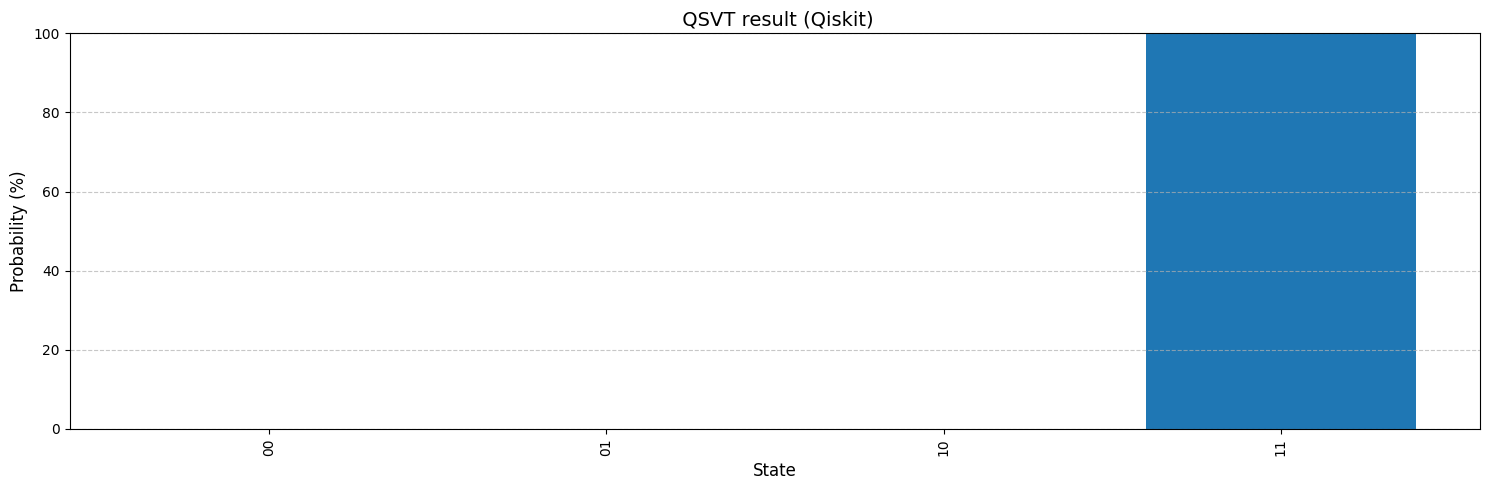

In [1]:
import numpy as np
import math # Math functions (used for pi)
import matplotlib.pyplot as plt # Plotting library for the histogram

# Import QuantumGateway and translators to different quantum frameworks
from quantumgateway.quantum_circuit import QuantumCircuit, QuantumGate
from quantumgateway.quantum_translator.braket_translator import BraketTranslator
from quantumgateway.quantum_translator.cirq_translator import CirqTranslator
from quantumgateway.quantum_translator.qiskit_translator import QiskitTranslator
from quantumgateway.quantum_translator.pennylane_translator import PennyLaneTranslator
from quantumgateway.quantum_translator.pyquil_translator import PyQuilTranslator
from quantumgateway.main import translate_to_framework, simulate_circuit


n = 3 # Total number of qubits: 2 data qubits + 1 ancilla
qc = QuantumCircuit(n, n) # Create the circuit with n qubits and n classical bits

# pi_c_not
def pi_c_not(qc):
        qc.add_gate(QuantumGate("h", [1]))
        qc.add_gate(QuantumGate("h", [2]))

        qc.add_gate(QuantumGate("x", [1]))
        qc.add_gate(QuantumGate("x", [2]))

        qc.add_gate(QuantumGate("toffoli",[1,2,0]))

        qc.add_gate(QuantumGate("x", [1]))
        qc.add_gate(QuantumGate("x", [2]))

        qc.add_gate(QuantumGate("h", [1]))
        qc.add_gate(QuantumGate("h", [2]))

# tilde_pi_c_not
def tilde_pi_c_not(qc):
    qc.add_gate(QuantumGate("toffoli", [1,2,0]))

# ----------------------------
# QSVT ANGLES
# ----------------------------
# Angles for Rz rotations applied to the ancilla in QSVT
angles = [math.pi, math.pi/2, math.pi/2]

# ----------------------------
# STATE PREPARATION
# ----------------------------
# Put the two data qubits (1 and 2) into uniform superposition |s> = (|00> + |01> + |10> + |11>)/2
qc.add_gate(QuantumGate("h", [1]))
qc.add_gate(QuantumGate("h", [2]))

# ----------------------------
# QSVT SEQUENCE
# ----------------------------
# Apply the Quantum Singular Value Transformation (QSVT) sequence

# First block: tilde_pi_c_not + ancilla rotation + tilde_pi_c_not
tilde_pi_c_not(qc)  # Initial Toffoli
qc.add_gate(QuantumGate("rz", [0], [2*angles[2]])) # Rotate ancilla
tilde_pi_c_not(qc)  # Toffoli again

# Second block: pi_c_not + ancilla rotation + pi_c_not
pi_c_not(qc)   # pi_c_not block
qc.add_gate(QuantumGate("rz", [0], [2*angles[1]]))  # Rotate ancilla
pi_c_not(qc)   # pi_c_not block again

# Third block: tilde_pi_c_not + final ancilla rotation + tilde_pi_c_not
tilde_pi_c_not(qc)  # Final Toffoli
qc.add_gate(QuantumGate("rz", [0], [2*angles[0]])) # Final rotation on ancilla
tilde_pi_c_not(qc)  # Final Toffoli


# ----------------------------
# MEASUREMENT
# ----------------------------
# Measure all three qubits (ancilla + data qubits)
qc.add_gate(QuantumGate("MEASURE", [0, 0]))
qc.add_gate(QuantumGate("MEASURE", [1, 1]))
qc.add_gate(QuantumGate("MEASURE", [2, 2]))

# ----------------------------
# SIMULATION
# ----------------------------
# Here we choose the framework we want to use (qiskit, cirq, pyquil, pennylane or amazonbraket)
# By default, we select qiskit
selected_framework = 'qiskit'
translated_circuit = translate_to_framework(qc, selected_framework)
translated_circuit.print_circuit() # Print the translated circuit

counts = simulate_circuit(qc, selected_framework)
print("Simulated counts (including ancilla):", counts)

# ----------------------------
# FILTERING RESULTS TO DATA QUBITS ONLY
# ----------------------------
# Qiskit returns bits as |q2 q1 q0> (most significant to least significant)
# We want only the data qubits (q2 and q1) and ignore the ancilla (q0)

filtered_counts = {}
for key, val in counts.items():
    # Take the first two bits which correspond to data qubits q2 and q1
    filtered_counts[key[0:2]] = val 

print("Filtered counts (only data qubits):", filtered_counts)

# ----------------------------
# NORMALIZE TO PERCENTAGE
# ----------------------------

# Sum the filtered counts to compute total shots (after collapsing ancilla).
total_shots = sum(filtered_counts.values())
# Convert counts to percentages (0–100)
percentage_counts = {state: count / total_shots * 100 for state, count in filtered_counts.items()}

# ----------------------------
# PREPARE DATA FOR PLOTTING
# ----------------------------
# Generate all possible 2-qubit states in binary order: '00', '01', '10', '11'
all_states = [format(i, '02b') for i in range(2**2)]
# Create a list of percentages for each possible state (fill missing states with 0)
probs = [percentage_counts.get(state, 0) for state in all_states]

# Mapping for pretty backend names in the plot title
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}
# ----------------------------
# HISTOGRAM
# ----------------------------
# Display the results of the data qubits in a histogram
plt.figure(figsize=(15,5))
plt.bar(all_states, probs)
plt.xlabel('State', fontsize=12)
plt.ylabel('Probability (%)', fontsize=12)
plt.title(f' QSVT result ({backend_names[selected_framework]})', fontsize=14)
plt.xticks(rotation='vertical')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

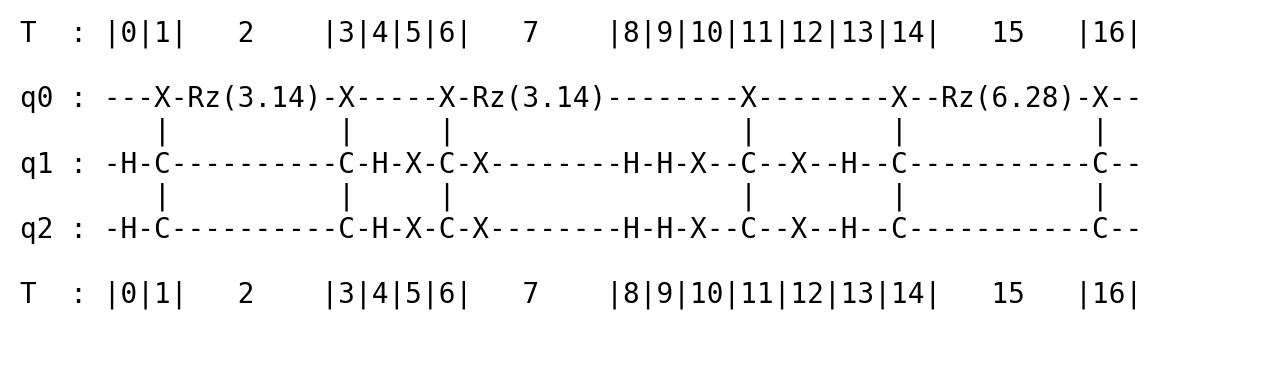

In [2]:
# The following is to save the circuit of each platform in an image
import matplotlib.pyplot as plt
import io
import sys

# Redirect stdout to capture circuit text
stdout = sys.stdout
sys.stdout = io.StringIO()

selected_framework = 'amazonbraket'  # Change this to the desired framework
translated_circuit = translate_to_framework(qc, selected_framework)
translated_circuit.print_circuit()

printed_circuit = sys.stdout.getvalue()
sys.stdout = stdout

# Split lines to estimate size
lines = printed_circuit.split("\n")
max_line_length = max(len(line) for line in lines)
num_lines = len(lines)

# Auto-adjust figure size based on text
scale = 1.8
fig_width = max_line_length * 0.12
fig_height = num_lines * 0.22

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=200)
ax.text(0, 1, printed_circuit,
        ha='left', va='top',
        family='monospace', fontsize=10,
        transform=ax.transAxes)


ax.axis('off')

# Save the figure with all extra space removed
plt.savefig("Fig8a.eps",
            dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()

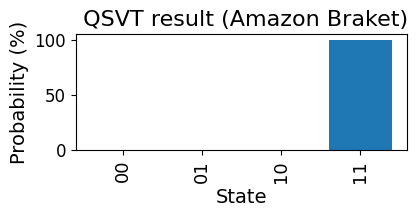

In [3]:
# and the following code is to save the image from the histogram

# Sum the filtered counts to compute total shots (after collapsing ancilla).
total_shots = sum(filtered_counts.values())
# Convert counts to percentages (0–100)
percentage_counts = {state: count / total_shots * 100 for state, count in filtered_counts.items()}

# ----------------------------
# PREPARE DATA FOR PLOTTING
# ----------------------------
# Generate all possible 2-qubit states in binary order: '00', '01', '10', '11'
all_states = [format(i, '02b') for i in range(2**2)]

# Create a narrower and taller figure
plt.figure(figsize=(4, 2))  # width=6, height=4 (adjust if needed)

# Create the bar plot
plt.bar(all_states, [percentage_counts.get(state, 0) for state in all_states])

# Mapping for pretty backend names in the plot title
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}

# Labels with larger fonts
plt.xlabel('State', fontsize=14)    
plt.ylabel('Probability (%)', fontsize=14)
plt.title(f' QSVT result ({backend_names[selected_framework]})', fontsize=16)

# More readable ticks
plt.xticks(rotation='vertical',fontsize=13)  # Rotate x-axis labels
plt.yticks(fontsize=12)

# Reduce whitespace at the bottom
#plt.subplots_adjust(bottom=0.1)  # ajusta este valor según lo necesario
# Remove extra white space
plt.tight_layout(pad=0.1)

# Save adjusted image
plt.savefig("Fig8b.eps",dpi=300, bbox_inches='tight', pad_inches=0.05)

# Show the histogram
plt.show()
